In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas_datareader.data as web
from utils import fetch_cmc_data


def reindex_fields(df, field_name, date_range):
    temp = (
        df.loc[
            df["Fields"] == field_name,
            
            ["Value", "As_of"],
        ]
    ).rename(columns={"Value": field_name})
    temp.set_index("As_of", inplace=True)
    temp = temp.reindex(date_range)
    temp.sort_index(inplace=True)
    temp.fillna(method="bfill", inplace=True)
    temp.fillna(method="ffill", inplace=True)
    return temp



In [58]:
# -------- Prepare the data --------
import pandas as pd
import pandas_datareader.data as web
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from api_key import CMC_API_KEY
from utils import fetch_cmc_data

In [ ]:
def plot_circulation_corr(start_date, end_date):
    read_start_date = start_date - datetime.timedelta(days=5)

    m2_data = (
        web.DataReader("WM2NS", "fred", read_start_date, end_date)
        .fillna(method="ffill")
        .loc[start_date:end_date]
    )
    spx_data = (
        web.DataReader("SP500", "fred", read_start_date, end_date)
        .fillna(method="ffill")
        .loc[start_date:end_date]
    )

    # # Merge M2 and SPX datasets

    # Fetch daily Bitcoin price data from FRED
    btc_data = web.DataReader("CBBTCUSD", "fred", start_date, end_date)
    btc_data.fillna(method="ffill", inplace=True)

    # Fetch daily USDC, USDT, and BUSD market cap data from CMC
    usdc_data = fetch_cmc_data("USDC").loc[start_date:end_date]
    usdt_data = fetch_cmc_data("USDT").loc[start_date:end_date]
    busd_data = fetch_cmc_data("BUSD").loc[start_date:end_date]

    # Combine USDT & BUSD as traidng stablecoins (ts)
    ts_data = usdt_data.merge(busd_data, left_index=True, right_index=True, how="outer")
    ts_data.fillna(0, inplace=True)
    ts_data["ts_market_cap"] = ts_data["USDT_market_cap"] + ts_data["BUSD_market_cap"]

    # -------- Calculate the correlation between M2 and SPX --------
    # Left join for resample purpose
    spx_m2 = m2_data.merge(spx_data, left_index=True, right_index=True, how="left")
    spx_m2.sort_index(inplace=True)
    spx_m2["m2_logchange"] = np.log(spx_m2["WM2NS"] / (spx_m2["WM2NS"].shift(1)))
    spx_m2["sp_logchange"] = np.log(spx_m2["SP500"] / (spx_m2["SP500"].shift(1)))

    corr_m2_spx = spx_m2[["m2_logchange", "sp_logchange"]].corr().iloc[0, 1]

    # -------- Calculate the correlation between USDC and BTC --------
    usdc_btc = usdc_data.merge(btc_data, left_index=True, right_index=True, how="inner")
    # Resample to weekly
    usdc_btc_weekly = usdc_btc.resample("W-MON").asfreq().loc[start_date:end_date]
    usdc_btc_weekly.dropna(how="any", axis=0, inplace=True)
    usdc_btc_weekly.sort_index(inplace=True)
    usdc_btc_weekly["usdc_mktcap_logchange"] = np.log(
        usdc_btc_weekly["USDC_market_cap"]
        / (usdc_btc_weekly["USDC_market_cap"].shift(1))
    )
    usdc_btc_weekly["btc_logchange"] = np.log(
        usdc_btc_weekly["CBBTCUSD"] / (usdc_btc_weekly["CBBTCUSD"].shift(1))
    )

    corr_usdc_btc = (
        usdc_btc_weekly[["usdc_mktcap_logchange", "btc_logchange"]].corr().iloc[0, 1]
    )

    # -------- Calculate the correlation between Trading stablecoins and BTC --------
    ts_btc = ts_data.merge(btc_data, left_index=True, right_index=True, how="inner")
    # Resample to weekly
    ts_btc_weekly = ts_btc.resample("W-MON").asfreq().loc[start_date:end_date]
    ts_btc_weekly.sort_index(inplace=True)
    ts_btc_weekly["ts_mktcap_logchange"] = np.log(
        ts_btc_weekly["ts_market_cap"] / (ts_btc_weekly["ts_market_cap"].shift(1))
    )
    ts_btc_weekly["btc_logchange"] = np.log(
        ts_btc_weekly["CBBTCUSD"] / (ts_btc_weekly["CBBTCUSD"].shift(1))
    )
    ts_btc_weekly.dropna(how="any", axis=0, inplace=True)

    corr_ts_btc = (
        ts_btc_weekly[["ts_mktcap_logchange", "btc_logchange"]].corr().iloc[0, 1]
    )

    # plot bar graph
    figure(figsize=(18, 12), dpi=300)

    ax = plt.axes()
    ax.set_axisbelow(True)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    plt.axhline(y=0, color="gray", linestyle="-")

    bars = plt.bar(
        ["USDC & BTC", "M2 & SPX", "Trading Stablecoins & BTC"],
        [corr_usdc_btc, corr_m2_spx, corr_ts_btc],
        width=0.75,
    )
    bars[0].set_color("#2775ca")
    bars[1].set_color("#c7c5d1")
    bars[2].set_color("#c7c5d1")
    ax.set_xticklabels(
        ["USDC &\nBTC", "U.S. Dollar (M2) &\nS&P 500", "Trading Stablecoins &\nBTC"],
        fontsize=30,
        font="Proxima Nova",
    )
    # plt.ylabel("Pearson Correlation", fontsize=14, font="Proxima Nova")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
    ax.set_yticklabels([0, 0.05, 0.1, 0.15, 0.2], fontsize=25, font="Proxima Nova")

    plt.savefig("../output/Figure2.png", format="png", dpi=300, bbox_inches="tight")


if __name__ == "__main__":
    plot_circulation_corr(
        start_date=datetime.datetime(2021, 1, 1),
        end_date=datetime.datetime(2023, 3, 31),
    )

In [ ]:
start_date=
read_start_date = start_date - datetime.timedelta(days=5)

m2_data = (
    web.DataReader("WM2NS", "fred", read_start_date, end_date)
    .fillna(method="ffill")
    .loc[start_date:end_date]
)
spx_data = (
    web.DataReader("SP500", "fred", read_start_date, end_date)
    .fillna(method="ffill")
    .loc[start_date:end_date]
)

# # Merge M2 and SPX datasets

# Fetch daily Bitcoin price data from FRED
btc_data = web.DataReader("CBBTCUSD", "fred", start_date, end_date)
btc_data.fillna(method="ffill", inplace=True)

# Fetch daily USDC, USDT, and BUSD market cap data from CMC
usdc_data = fetch_cmc_data("USDC").loc[start_date:end_date]
usdt_data = fetch_cmc_data("USDT").loc[start_date:end_date]
busd_data = fetch_cmc_data("BUSD").loc[start_date:end_date]

# Combine USDT & BUSD as traidng stablecoins (ts)
ts_data = usdt_data.merge(busd_data, left_index=True, right_index=True, how="outer")
ts_data.fillna(0, inplace=True)
ts_data["ts_market_cap"] = ts_data["USDT_market_cap"] + ts_data["BUSD_market_cap"]

# -------- Calculate the correlation between M2 and SPX --------
# Left join for resample purpose
spx_m2 = m2_data.merge(spx_data, left_index=True, right_index=True, how="left")
spx_m2.sort_index(inplace=True)
spx_m2["m2_logchange"] = np.log(spx_m2["WM2NS"] / (spx_m2["WM2NS"].shift(1)))
spx_m2["sp_logchange"] = np.log(spx_m2["SP500"] / (spx_m2["SP500"].shift(1)))

corr_m2_spx = spx_m2[["m2_logchange", "sp_logchange"]].corr().iloc[0, 1]

# -------- Calculate the correlation between USDC and BTC --------
usdc_btc = usdc_data.merge(btc_data, left_index=True, right_index=True, how="inner")
# Resample to weekly
usdc_btc_weekly = usdc_btc.resample("W-MON").asfreq().loc[start_date:end_date]
usdc_btc_weekly.dropna(how="any", axis=0, inplace=True)
usdc_btc_weekly.sort_index(inplace=True)
usdc_btc_weekly["usdc_mktcap_logchange"] = np.log(
    usdc_btc_weekly["USDC_market_cap"]
    / (usdc_btc_weekly["USDC_market_cap"].shift(1))
)
usdc_btc_weekly["btc_logchange"] = np.log(
    usdc_btc_weekly["CBBTCUSD"] / (usdc_btc_weekly["CBBTCUSD"].shift(1))
)

corr_usdc_btc = (
    usdc_btc_weekly[["usdc_mktcap_logchange", "btc_logchange"]].corr().iloc[0, 1]
)

In [3]:
df = pd.read_csv(
    "../data/other_data_source.csv",
    parse_dates=["As_of"],
    usecols=["Fields", "Value", "As_of"],
)

# Fetch daily USDC, USDT, and BUSD market cap data from CMC
usdc_data = fetch_cmc_data("USDC")#.loc[start_date:end_date]
usdt_data = fetch_cmc_data("USDT")#.loc[start_date:end_date]
busd_data = fetch_cmc_data("BUSD")#.loc[start_date:end_date]


{'symbol': 'USDC', 'interval': 'daily', 'count': 1825, 'convert': 'USD', 'aux': 'volume,market_cap'}
{'symbol': 'USDT', 'interval': 'daily', 'count': 1825, 'convert': 'USD', 'aux': 'volume,market_cap'}
{'symbol': 'BUSD', 'interval': 'daily', 'count': 1825, 'convert': 'USD', 'aux': 'volume,market_cap'}


In [23]:

def plot_speculative_ratio(start_date, end_date, df, usdc_data, usdt_data, busd_data):
    usdc_data = usdc_data.loc[start_date:end_date]
    usdt_data = usdt_data.loc[start_date:end_date]
    busd_data = busd_data.loc[start_date:end_date]
    
    # Combine USDT & BUSD as traidng stablecoins (ts)
    ts_data = usdt_data.merge(busd_data, left_index=True, right_index=True, how="outer")
    ts_data.fillna(0, inplace=True)
    ts_data["ts_market_cap"] = ts_data["USDT_market_cap"] + ts_data["BUSD_market_cap"]
    ts_data["ts_volume"] = ts_data["USDT_volume"] + ts_data["BUSD_volume"]

    # calculate stablecoin ratios
    usdc_ratio = (usdc_data["USDC_volume"] / usdc_data["USDC_market_cap"]).mean()
    trading_stablecoin_ratio = (ts_data["ts_volume"] / ts_data["ts_market_cap"]).mean()

    # --------------- calculate retail brokerage ratio ---------------
    date_range = pd.date_range(start=start_date, end=end_date)
    schwab_dats = (df.loc[df["Fields"] == "schwab_dats", ["Value", "As_of"]]).rename(
        columns={"Value": "schwab_dats"}
    )
    avg_retail_trade_size = (
        df.loc[df["Fields"] == "avg_retail_trade_size", "Value"]
    ).values[0]
    schwab_bda_balance = (
        df.loc[df["Fields"] == "schwab_bda", ["Value", "As_of"]]
    ).rename(columns={"Value": "schwab_bda"})

    schwab_df = schwab_dats.merge(schwab_bda_balance, on="As_of", how="left")
    schwab_df.sort_values(by=["As_of"], inplace=True)
    schwab_df.fillna(method="ffill", inplace=True)
    schwab_ratio = (
        (schwab_df["schwab_dats"] * 1000 * avg_retail_trade_size)
        / (schwab_df["schwab_bda"] * 1e6)
    ).mean()

    # ---------------calculate USD ratio ---------------
    # M2 data
    read_start_date = start_date - datetime.timedelta(days=5)
    m2_data = (
        web.DataReader("WM2NS", "fred", read_start_date, end_date)
        .fillna(method="ffill")
        .loc[start_date:end_date]
    )
    # Read in FX data from BIS
    fx_data = reindex_fields(
        df, "usd_denominated_fx_spot_and_forward_volume", date_range
    )

    # Read in equity data
    equity_data = reindex_fields(df, "us_equity_volume", date_range)

    # Read in fixed income data
    fixed_income_data = reindex_fields(df, "us_fixed_income_volume", date_range)

    # merge dataframes
    usd_df = m2_data.merge(fx_data, left_index=True, right_index=True, how="left")
    usd_df = usd_df.merge(equity_data, left_index=True, right_index=True, how="left")
    usd_df = usd_df.merge(
        fixed_income_data, left_index=True, right_index=True, how="left"
    )

    usd_ratio = (
        (
            usd_df["usd_denominated_fx_spot_and_forward_volume"] * 1e6
            + usd_df["us_equity_volume"] * 1e9
            + usd_df["us_fixed_income_volume"] * 1e9
        )
        / (usd_df["WM2NS"] * 1e9)
    ).mean()
    # plot bar graph
    figure(figsize=(16, 12), dpi=300)

    ax = plt.axes()
    ax.set_axisbelow(True)
    ax.xaxis.grid(False)
    # ax.yaxis.grid(color="gray", linestyle="-", linewidth=0.5)

    bars = plt.bar(
        ["USDC", "U.S. Dollar", "Retail Brokerage", "Trading Stablecoins"],
        [
            usdc_ratio,
            usd_ratio,
            schwab_ratio,
            trading_stablecoin_ratio,
        ],
        width=0.75,
    )
    bars[0].set_color("#2775ca")
    bars[1].set_color("#c7c5d1")
    bars[2].set_color("#c7c5d1")
    bars[3].set_color("#c7c5d1")
    ax.set_xticklabels(
        ["USDC", "U.S. Dollar\n(M2)", "Retail\nBrokerage", "Trading\nStablecoins"],
        fontsize=30,
       )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.yticks(
        [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2],
        labels=["0", "0.2", "0.4", "0.6", "0.8", "1.0", "1.2"],
        fontsize=25,
    )
    plt.show()
    # plt.savefig("../output/Figure1.png", format="png", dpi=300, bbox_inches="tight")


In [121]:
dryT=pd.DataFrame({'Trading Stablecoins':(usdt_data["USDT_volume"]+busd_data["BUSD_volume"]) / (usdt_data["USDT_market_cap"]+busd_data["BUSD_market_cap"])}).resample('Y').mean()

dryT=dryT.loc['2019':'2023']

dryT.index=dryT.index.year

dry=(usdc_data["USDC_volume"].resample('Y').mean()/usdc_data["USDC_market_cap"].resample('Y').mean())

dry=dry.loc['2019':'2023']

dry.index=dry.index.year

dry.name='USDC'

<Figure size 300x400 with 0 Axes>

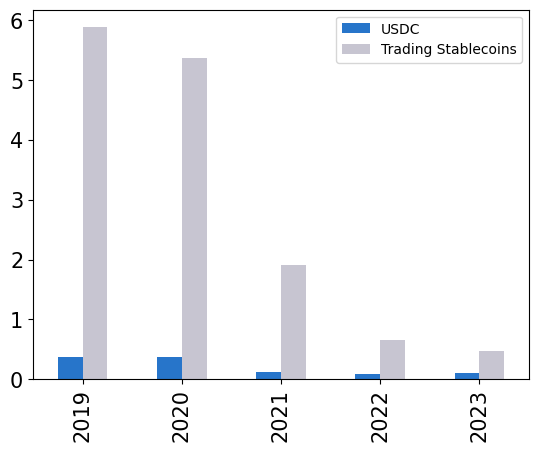

In [123]:
plt.figure(figsize=(3, 4))
pd.merge(dry,dryT,left_index=True,right_index=True).plot(kind='bar',color=["#2775ca","#c7c5d1"],fontsize=15)
plt.savefig('../output/SpecRatio_ts.png', bbox_inches="tight")

<Axes: >

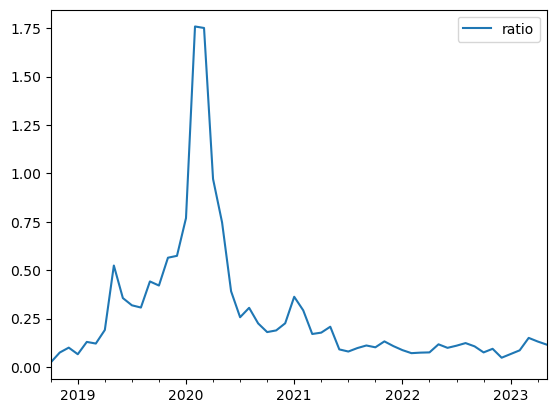

In [37]:
dr.resample('M').mean().plot()

C:\Users\Gordon\AppData\Local\Temp\ipykernel_15512\4128660842.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


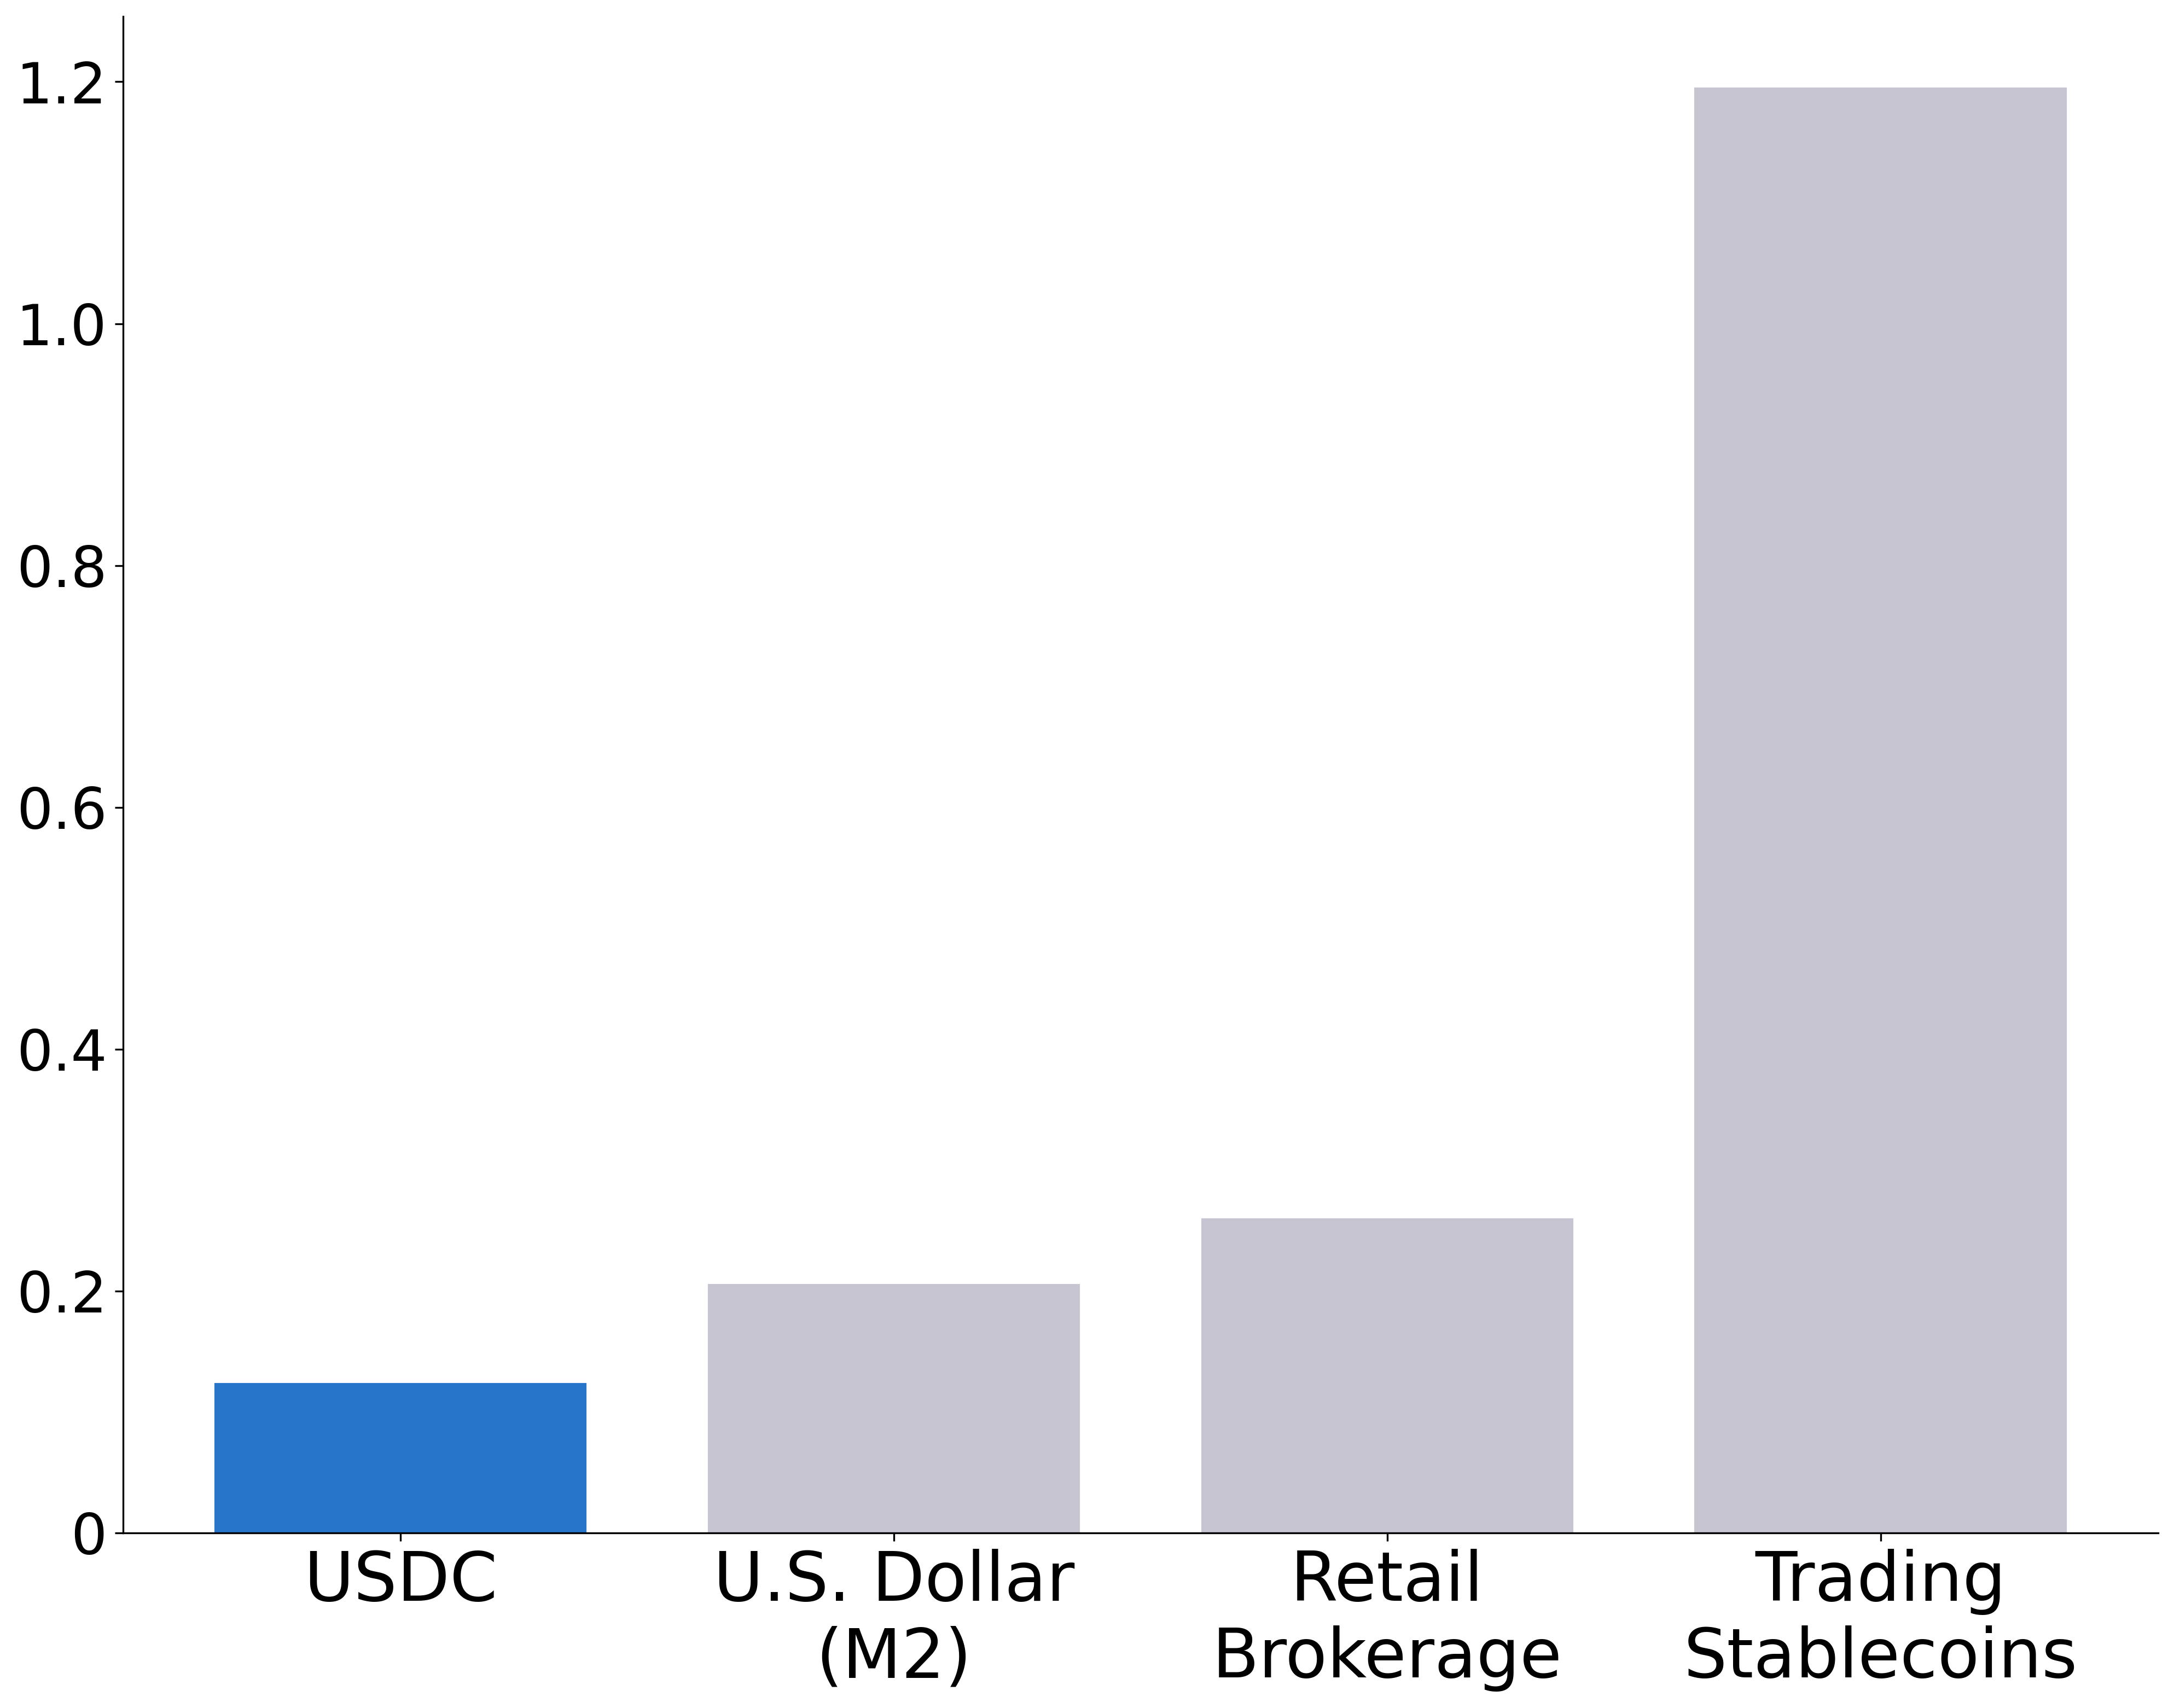

In [29]:
plot_speculative_ratio(datetime.datetime(2021, 1, 1),
                       datetime.datetime(2023, 3, 31),
                       df, usdc_data, usdt_data, busd_data)

C:\Users\Gordon\AppData\Local\Temp\ipykernel_15512\4128660842.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


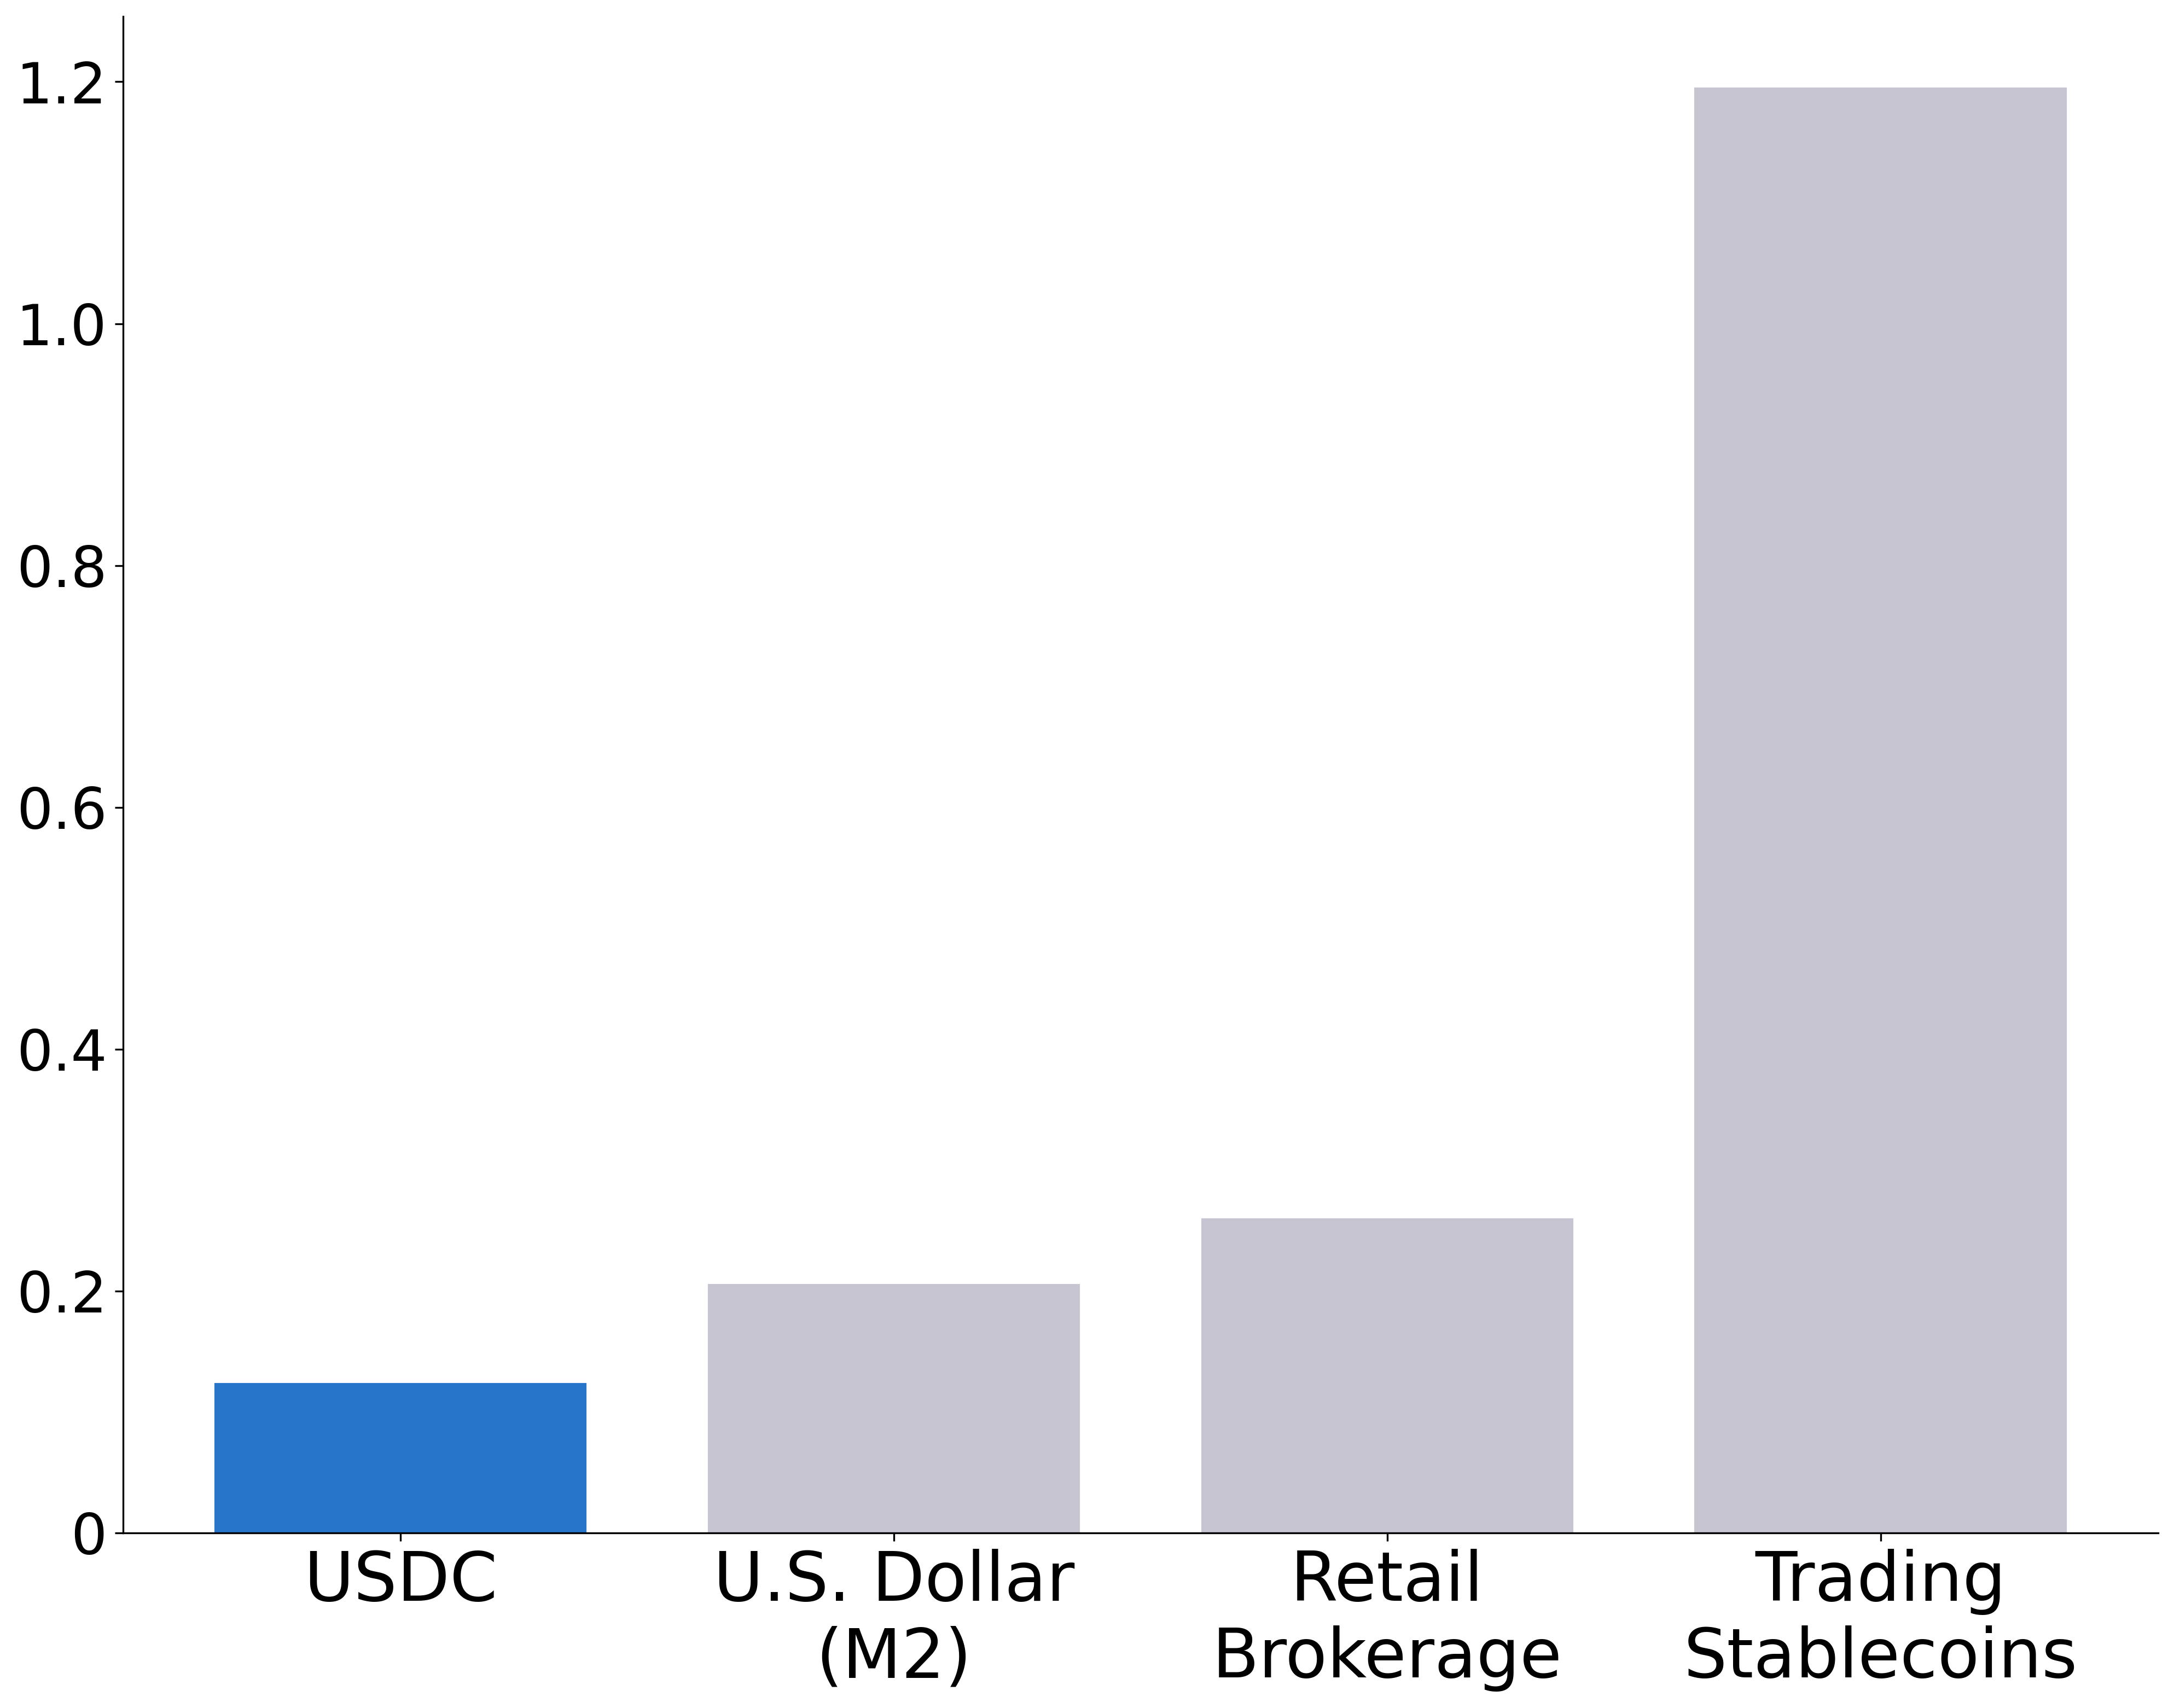

In [22]:
plot_speculative_ratio(datetime.datetime(2021, 1, 1),
                       datetime.datetime(2023, 3, 31),
                       df, usdc_data, usdt_data, busd_data)

In [ ]:


if __name__ == "__main__":
    plot_speculative_ratio(
        start_date=datetime.datetime(2021, 1, 1),
        end_date=datetime.datetime(2023, 3, 31),
    )
